# Arabic_MNIST_Character_Classification

Inspired by the well studied MNIST Classification problem and the results achieved by Ahmed Elsawy, Mohamed Loey and Hazem El-Bakry in ,,***Arabic Handwritten Characters Recognition using Convolutional Neural Network***'' I decided to challange myself and share my results.

In [4]:
from utils import *
from fastai2.vision.all import *

## Getting the Data
### Navigating to the dataset directory

In [5]:
# Show what's inside the directory
path = Path('/notebooks/storage/data/arabic_mnist')
path.ls()

(#3) [Path('/notebooks/storage/data/arabic_mnist/train'),Path('/notebooks/storage/data/arabic_mnist/.ipynb_checkpoints'),Path('/notebooks/storage/data/arabic_mnist/test')]

We are mainly interested in the train and test directory. However, in order to use helpful fastai methods it is convenient to rename the "test" directory to "valid"

In [6]:
# Rename test to valid
! mv {path / 'test'} {path / 'valid'}

In [7]:
path.ls()

(#3) [Path('/notebooks/storage/data/arabic_mnist/valid'),Path('/notebooks/storage/data/arabic_mnist/train'),Path('/notebooks/storage/data/arabic_mnist/.ipynb_checkpoints')]

### Looking at the data filenames

In [8]:
train_data = path/"train/train"
train_data.ls()[:10], len(train_data.ls())

((#10) [Path('/notebooks/storage/data/arabic_mnist/train/train/id_5374_label_28.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_8290_label_1.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_3424_label_8.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_6270_label_28.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_6026_label_26.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_5237_label_11.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_7807_label_24.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_4456_label_25.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_2777_label_12.png'),Path('/notebooks/storage/data/arabic_mnist/train/train/id_9003_label_6.png')],
 13440)

In [9]:
valid_data = path/"valid/valid"
valid_data.ls()[:10], len(valid_data.ls())

((#10) [Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_3064_label_20.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_2129_label_1.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_2225_label_21.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_2840_label_20.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_1293_label_3.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_3184_label_24.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_3054_label_15.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_296_label_8.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_434_label_21.png'),Path('/notebooks/storage/data/arabic_mnist/valid/valid/id_99_label_22.png')],
 3360)

Here we can see that the filenames contain the labels. The numbers from zero to 28 indicate the 28 main characters (also called harfs) of the Arabic alphabet. To make it easier for humans to interpret the classification results, we will re-label the numeric label to a designated label such as the character identifier. 

> The spelling of each character Arabic character depends on it's location in the word. Therefore the same character can look different if it begins a word, ends a word on is written between two other characters.

We will start by creating the labels that we want to use instead of the corresponding numeric label

#### Encode numeric labels to identifier

In [10]:
arabic_mnist_labels = ['alef','beh','teh','theh','jeem','hah','khah','dal','thal','reh','zain','seen',
                'sheen','sad','dad','tah','zah','ain','ghain','feh','qaf','kaf','lam','meem',
                'noon','heh','waw','yeh']

Now we need to think about how to to map the filenames to our arabic_mnist_labels.designation. One convenient way is to use regular expressions.
<br> 
We could analyze the path : /notebooks/storage/data/arabic_mnist/train/id_5374_**label_28.png** <br>and wait for "**label**" follwed by underscore **_** followed by numbers "**28**" followed by "**.png**" an only catch the numbers.

In [11]:
# Looking at the example we can see that we need the following expression:
reg_expression = "label_(.+).png"

In [12]:
# Example
import re

full_path = "/notebooks/storage/data/arabic_mnist/train/id_5374_label_28.png"
x = re.findall("label_(.+).png", full_path) 
x

['28']

#### Create our custom labeling function
Keep in mind that the numeric labels start from 1 - 28, whereas our arabic_mnist_labels start from 0 - 27

In [13]:
def get_arabic_mnist_labels(file_path):
    regex = "label_(.+).png"
    label = re.search(regex, str(file_path)).group(1)
    return arabic_mnist_labels[int(label)-1] # adapt index

get_arabic_mnist_labels("/notebooks/storage/data/arabic_mnist/train/id_5374_label_1.png")

'alef'

### Create the Datablock

In [15]:
arab_mnist = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(),
                 get_y=get_arabic_mnist_labels, 
                       item_tfms=Resize(460),
                 batch_tfms=[*aug_transforms(do_flip = False, size=224, min_scale=0.85), 
                             Normalize.from_stats(*imagenet_stats)]
                )
#source
dls = arab_mnist.dataloaders(path)

#### Check the labels

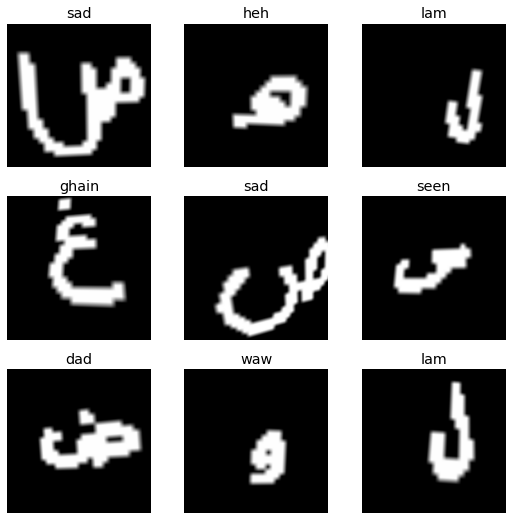

In [16]:
dls.show_batch(nrows=3, ncols=3)

# Training Procedure

#### Create the learner and setup resnet18 architecture

In [19]:
learn = cnn_learner(dls, resnet18, pretrained=True, loss_func = CrossEntropyLossFlat(), metrics=accuracy, model_dir="/tmp/model/")

#### Pick learning rate

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.013182567432522774)

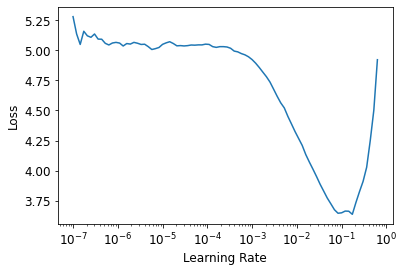

In [20]:
learn.lr_find()

In [41]:
lr = 1e-2

In [22]:
learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.202284,0.493415,0.845536,00:35
1,0.607610,0.440234,0.870238,00:35
2,0.592418,0.550815,0.840476,00:36
3,0.496948,0.406361,0.883631,00:35
4,0.387684,0.367163,0.897024,00:35
5,0.338288,0.225324,0.930655,00:35
6,0.302022,0.200583,0.940179,00:35
7,0.275194,0.171209,0.950000,00:35
8,0.208208,0.151495,0.953869,00:35
9,0.192402,0.168168,0.952976,00:35


At this point, the result achieved by Ahmed Elsawy, Mohamed Loey and Hazem El-Bakry are beaten<br>
Of course, there is still room to improve the model if needed. 

#### Export weights

In [25]:
learn.save("arabic_mnist_cnn_resnet18")

In [34]:
learn = learn.load("arabic_mnist_cnn_resnet18")

### Fine-tuning the Neural Net

In [35]:
learn.unfreeze()

SuggestedLRs(lr_min=1.4454397387453355e-06, lr_steep=6.309573450380412e-07)

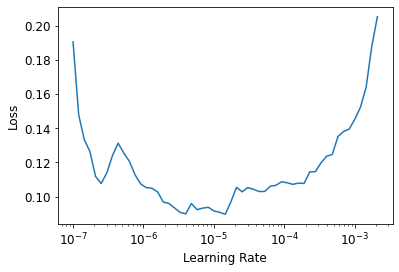

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(7, lr_max=slice(10e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.105011,0.114719,0.966667,00:42
1,0.126857,0.120385,0.963690,00:42
2,0.113619,0.111537,0.964583,00:43
3,0.105308,0.103795,0.968750,00:43
4,0.084178,0.098413,0.969940,00:43
5,0.079669,0.097640,0.967857,00:43
6,0.073625,0.096897,0.970833,00:43


### Conclusion after fine-tuning
At this point, we are satisfied with the result. 
<br>We could continue fine-tuning to achieve some overfitting. Which is the case if the train_loss is a little bit smaller than the valid_loss. Some deep learning theorists would probably advise against this, but in practice, a slight overfit is actually good. What we are ultimately interested in is that our metric (here the accuracy) is as high as possible and that the valid_loss is as low as possible.

#### Export weights

In [38]:
learn.save("arabic_mnist_cnn_resnet18_after_finetuning_1")

In [40]:
learn = learn.load("arabic_mnist_cnn_resnet18_after_finetuning_1")

# Model Analysis

In [42]:
interp = ClassificationInterpretation.from_learner(learn)

#### Looking at the confusion Matrix
Due to the fact that the dataset has 28 classes analyzing the confusion matrix is a bit cumbersome.

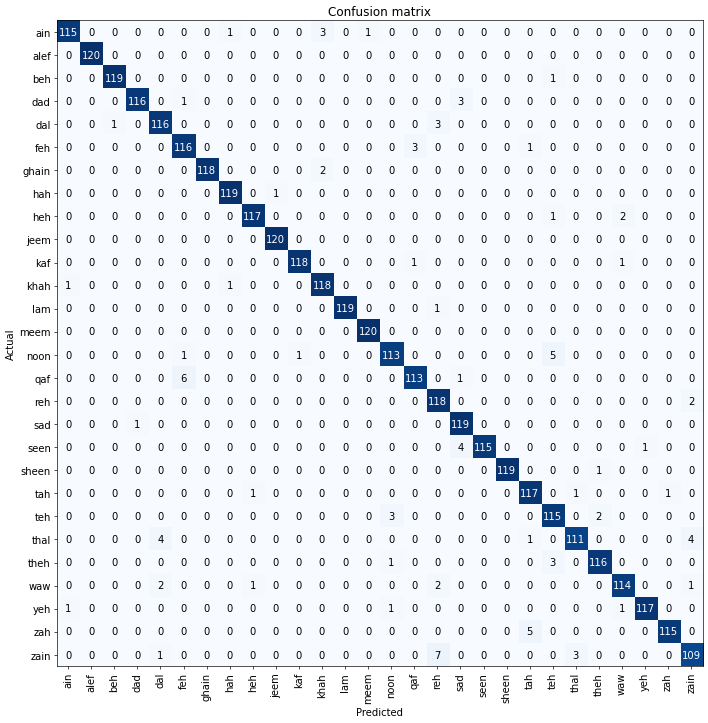

In [44]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

#### Check the classifications that contributed to the loss the most

In [45]:
interp.most_confused(min_val=3)

[('zain', 'reh', 7),
 ('qaf', 'feh', 6),
 ('noon', 'teh', 5),
 ('zah', 'tah', 5),
 ('seen', 'sad', 4),
 ('thal', 'dal', 4),
 ('thal', 'zain', 4),
 ('ain', 'khah', 3),
 ('dad', 'sad', 3),
 ('dal', 'reh', 3),
 ('feh', 'qaf', 3),
 ('teh', 'noon', 3),
 ('theh', 'teh', 3),
 ('zain', 'thal', 3)]

#### Look at prediction vs target batches 
After talking to native Arabic speakers we found that cleaning the dataset would increase the accuracy, hence a lot of the chars are written poorly. A quick search on google confirmed that the first image below (feh/noon) look extremely similar and would probably also be wrongly classified by humans.

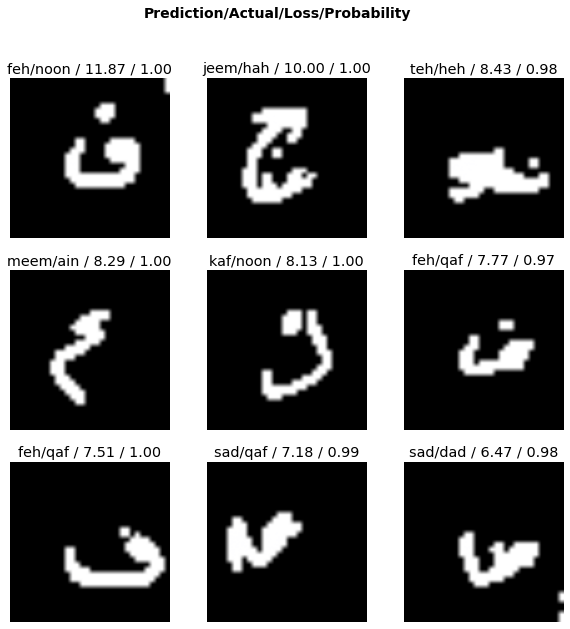

In [48]:
interp.plot_top_losses(9, figsize=(10,10))